# Import Data
- Each row will represent a __single season's statistics__ from a single player.
- Most players will have multiple rows, as most played multiple seasons.

In [1]:
# helper.py
from helper import *

In [2]:
# get passing data
pass_df = load_pass_data()

# get rushing data
rush_df = load_rush_data()

# left join to ensure we keep all QBs with passing data, as this is more important than rushing data
df = pass_df.merge(rush_df, on=['player', 'year'], how='left')

# view duplicate players and unique QBs
df.duplicated().sum(), len(set(df.player))

(0, 289)

- No duplicate players.
- 289 unique NFL quarterbacks.

In [3]:
# view shape and nulls
show_shape_and_nulls(df)

Shape: (1323, 64)
Null values:


,player,team_name,player_game_count,pass_accuracy_percent,pass_aimed_passes,pass_attempts,pass_avg_depth_of_target,pass_avg_time_to_throw,pass_bats,pass_big_time_throws,pass_btt_rate,pass_completion_percent,pass_completions,pass_def_gen_pressures,pass_drop_rate,pass_dropbacks,pass_drops,pass_first_downs,pass_grades_hands_fumble,pass_grades_offense,pass_grades_pass,pass_hit_as_threw,pass_interceptions,pass_passing_snaps,pass_penalties,pass_pressure_to_sack_rate,pass_qb_rating,pass_sack_percent,pass_sacks,pass_scrambles,pass_spikes,pass_thrown_aways,pass_touchdowns,pass_turnover_worthy_plays,pass_twp_rate,pass_yards,pass_ypa,year,rush_attempts,rush_avoided_tackles,rush_breakaway_attempts,rush_breakaway_percent,rush_breakaway_yards,rush_designed_yards,rush_elu_recv_mtf,rush_elu_rush_mtf,rush_elu_yco,rush_elusive_rating,rush_explosive,rush_first_downs,rush_fumbles,rush_gap_attempts,rush_grades_offense_penalty,rush_grades_run,rush_longest,rush_run_plays,rush_scramble_yards,rush_total_touches,rush_touchdowns,rush_yards,rush_yards_after_contact,rush_yco_attempt,rush_ypa,rush_zone_attempts
0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,97,97,97,109,97,97,97,97,149,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97


- 1323 QB seasons.
- Very few nulls in the passing columns.
- Around 100 nulls in the rushing columns.
- These values will be imputed with 0.

In [4]:
# fill nulls with 0 and check
df = df.fillna(0)
df.isnull().sum().sum()

0

# Experience
- An "exp" feature will be added to represent the player's __years of experience__. For example, a rookie quarterback would have exp=0.
- 2006 QBs will need to be handeled uniquely, as most are not rookies.
- I manually found the experience of players in the 2006 season. This is found in the [helper file](./helper.py).

In [5]:
# add experience col to df
df['exp'] = np.nan

# add experience for 2006 QBs
df.loc[df['year'] == 2006, 'exp'] = df.loc[df['year'] == 2006, 'player'].map(EXP_2006)

# check
df[['player', 'exp', 'year']].head()

,player,exp,year
0,Brett Favre,15.0,2006
1,Jon Kitna,10.0,2006
2,Marc Bulger,6.0,2006
3,Peyton Manning,8.0,2006
4,Drew Brees,5.0,2006


- QBs who played in 2006 season have an "exp" value, non-2006 QBs have NaN value.

In [6]:
# group by index and fill experience values, drop multi-index
df = df.groupby('player').apply(fill_experience)

# Patrick Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'exp']]

,player,year,exp
853,Patrick Mahomes,2017,0
875,Patrick Mahomes,2018,1
956,Patrick Mahomes,2019,2
1012,Patrick Mahomes,2020,3
1090,Patrick Mahomes,2021,4
1166,Patrick Mahomes,2022,5
1248,Patrick Mahomes,2023,6


- All players now have a corresponding experience for each of their seasons.

# Target Variable
- For each season __x__, the target is the grades_offense stat of season __x + 1__.

In [7]:
# ensure values are sorted properly
df = df.sort_values(by=['player', 'year']).reset_index(drop=True)

# add target col
df['target'] = df.groupby('player')['pass_grades_offense'].shift(-1)

# Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'pass_grades_offense', 'target']]

,player,year,pass_grades_offense,target
1007,Patrick Mahomes,2017,72.6,93.2
1008,Patrick Mahomes,2018,93.2,83.6
1009,Patrick Mahomes,2019,83.6,91.4
1010,Patrick Mahomes,2020,91.4,77.1
1011,Patrick Mahomes,2021,77.1,91.3
1012,Patrick Mahomes,2022,91.3,85.1
1013,Patrick Mahomes,2023,85.1,NaN


- Players in their final season will have a NaN value for the target variable (as seen above).
- These rows cannot be used to train model, as we don't have the grades_offense stat of the next year (it doesn't exist).

In [8]:
# drop rows with null target (players in their final season and most recent season)
df = df.dropna(subset=['target'])
df.isnull().sum().sum() 

0

# Past Performance

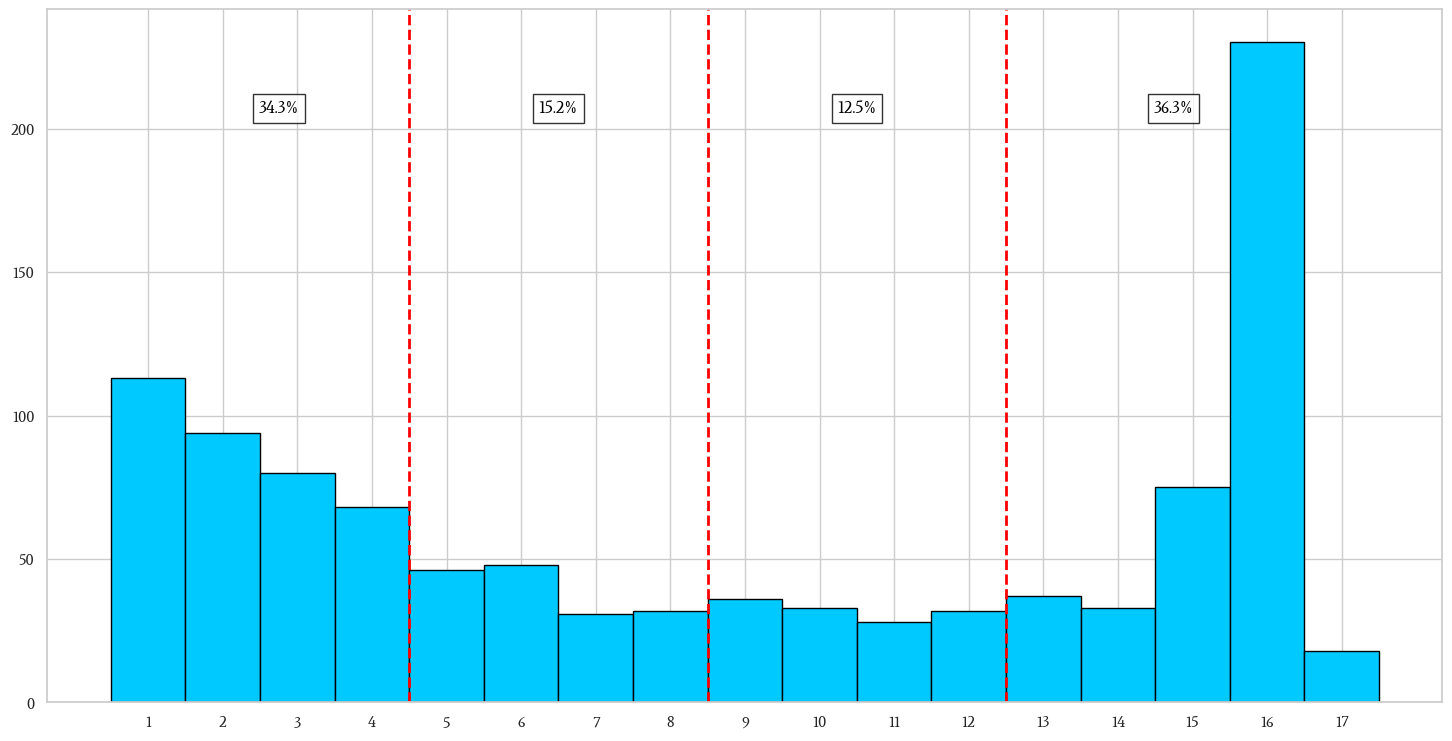

In [73]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'player_game_count', vertical_lines=[4.5, 8.5, 12.5], color=COLORS[0])

- Only 36% of the rows represent a season where a QB played at least 13 games.
- The other 64% represents seasons in which starting QBs were injured, or just seasons from backup QBs who only play in a few games.

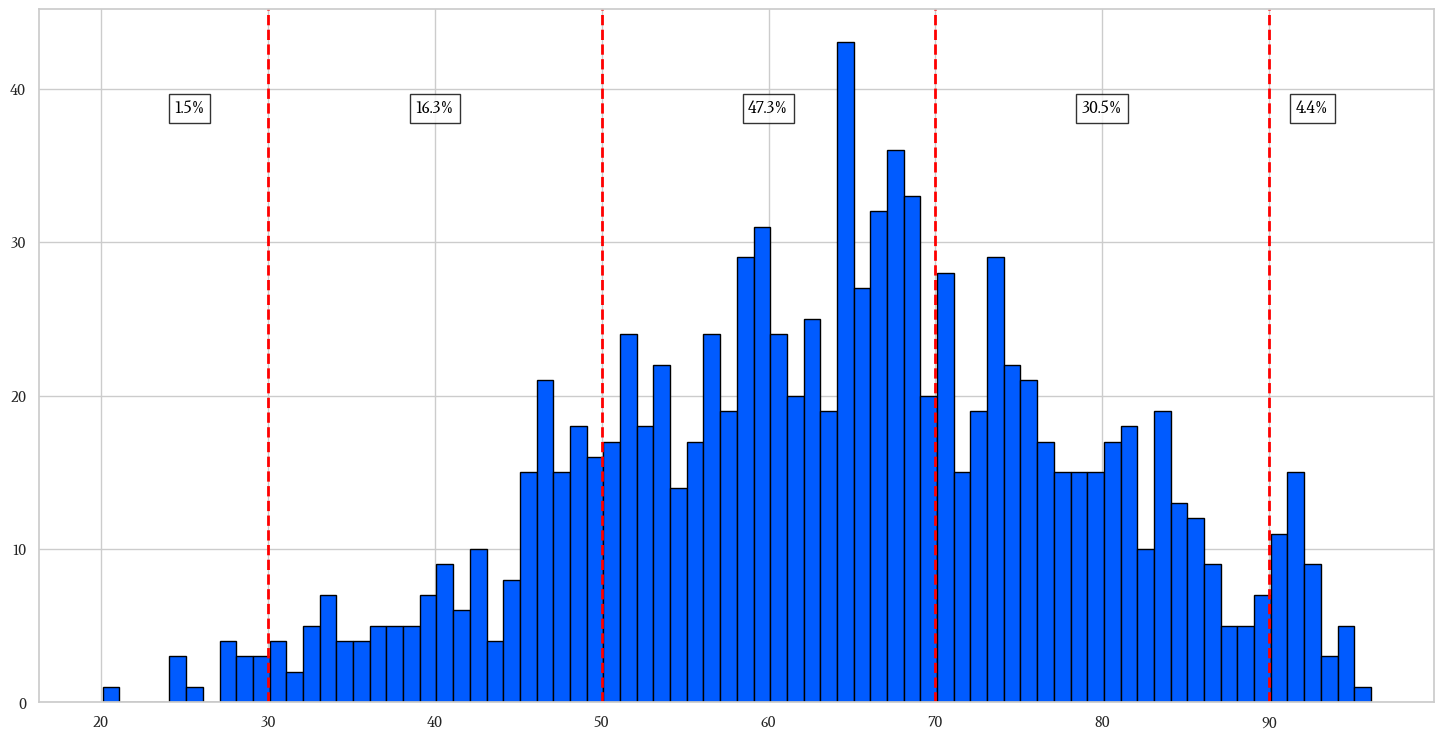

,count,mean,std,min,25%,50%,75%,max
pass_grades_offense,1034.0,64.012186,14.800543,20.6,53.8,64.7,74.375,95.2


In [75]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'pass_grades_offense', xticklabels=[20 ,30, 40, 50, 60, 70, 80, 90], vertical_lines=[30, 50, 70, 90], color=COLORS[1])

# distribution of offensive grades
df[['pass_grades_offense']].describe().T

- Average offensive grade of 64.
- Only 35% of seasons end with an offensive fgrade north of 70.
- Only 4% end with an elite offensive grade above 90.

,pass_grades_offense,pass_grades_pass,rush_grades_run
pass_grades_offense,1.000000,0.966973,0.240137
pass_grades_pass,0.966973,1.000000,0.116990
rush_grades_run,0.240137,0.116990,1.000000


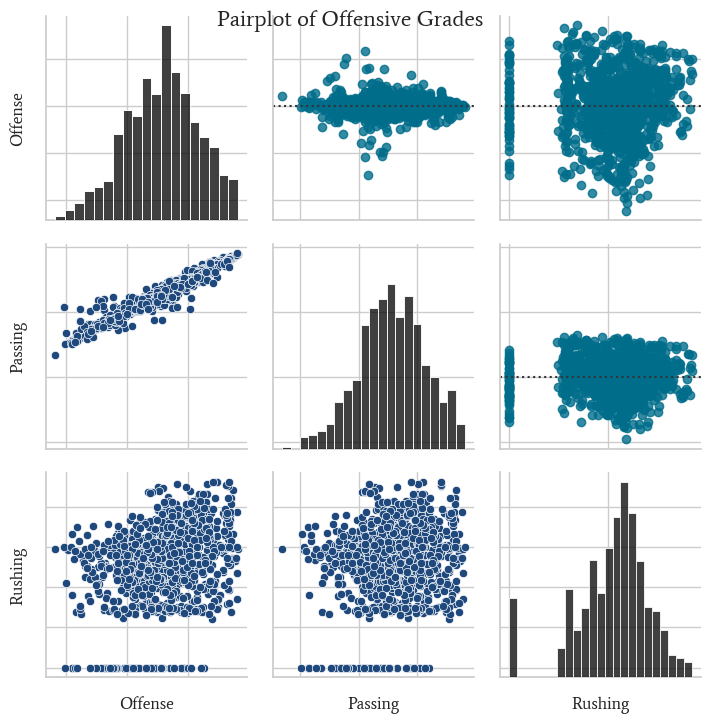

In [14]:
# correlation
display(df[['pass_grades_offense', 'pass_grades_pass', 'rush_grades_run']].corr())

# plot pairplot of grade metrics
plot_pairplot(df)

- Passing grade correlates very strongly with a QB's overall offensive grade (0.97 correlation).
- Rush grade has a much smaller correlation with offensive grade at 0.24. Rush grade correlates even less with passing grade with a correlation of only 0.11.
- This makes sense, as the quarterback position is primarily responsible for passing the football. Although rushing QBs have become more standard in today's league, a QB's ability to pass the football effictively and consistently has a much greater impact on their offensive performance than their rushing capabilities.

# Past Predictors
How many seasons prior are useful to predicting a QB's performance in the next season? This analysis will help us in creating features for the modeling process.

In [12]:
# create year groups
year_groups = [1, 2, 3, 4, 5, 10]

# initialize df_agg with one row per player
df_agg = pd.DataFrame({'player': df['player'].unique()})

# loop through each year group
for n in year_groups:
    col_name = f'pass_grade_offense_{n}year_mean'
    
    # compute mean for each player's first n years
    temp = (
        df[df['exp'] < n]
        .groupby('player')['pass_grades_offense']
        .mean()
        .rename(col_name)
        .reset_index()
    )
    
    # merge the new column into df_agg on 'player'
    df_agg = df_agg.merge(temp, on='player', how='left')


In [19]:
df.query('player == "A.J. Feeley"')[['player', 'year', 'pass_grades_offense', 'exp']]

,player,year,pass_grades_offense,exp
0,A.J. Feeley,2006,64.3,5
1,A.J. Feeley,2007,41.2,6
2,A.J. Feeley,2011,50.0,7


In [13]:
df_agg

,player,pass_grade_offense_1year_mean,pass_grade_offense_2year_mean,pass_grade_offense_3year_mean,pass_grade_offense_4year_mean,pass_grade_offense_5year_mean,pass_grade_offense_10year_mean
0,A.J. Feeley,NaN,NaN,NaN,NaN,NaN,51.833333
1,A.J. McCarron,69.7,53.40,48.00,50.70,53.380,54.316667
2,Aaron Brooks,NaN,NaN,NaN,NaN,NaN,57.500000
3,Aaron Rodgers,NaN,30.30,48.20,58.50,65.825,79.188889
4,Aidan O'Connell,65.9,65.90,65.90,65.90,65.900,65.900000
...,...,...,...,...,...,...,...
284,Vinny Testaverde,NaN,NaN,NaN,NaN,NaN,NaN
285,Will Grier,29.0,29.00,29.00,29.00,29.000,29.000000
286,Will Levis,63.7,63.70,63.70,63.70,63.700,63.700000
287,Zach Mettenberger,56.7,47.55,47.55,47.55,47.550,47.550000


- I will look at each player's offensive grade over their 3 most recent seasons, and use the mean (capturing peformance) along with the standard deviation (capturing consistency).

In [16]:
df

,player,team_name,player_game_count,pass_accuracy_percent,pass_aimed_passes,pass_attempts,pass_avg_depth_of_target,pass_avg_time_to_throw,pass_bats,pass_big_time_throws,pass_btt_rate,pass_completion_percent,pass_completions,pass_def_gen_pressures,pass_drop_rate,pass_dropbacks,pass_drops,pass_first_downs,pass_grades_hands_fumble,pass_grades_offense,pass_grades_pass,pass_hit_as_threw,pass_interceptions,pass_passing_snaps,pass_penalties,pass_pressure_to_sack_rate,pass_qb_rating,pass_sack_percent,pass_sacks,pass_scrambles,pass_spikes,pass_thrown_aways,pass_touchdowns,pass_turnover_worthy_plays,pass_twp_rate,pass_yards,pass_ypa,year,rush_attempts,rush_avoided_tackles,rush_breakaway_attempts,rush_breakaway_percent,rush_breakaway_yards,rush_designed_yards,rush_elu_recv_mtf,rush_elu_rush_mtf,rush_elu_yco,rush_elusive_rating,rush_explosive,rush_first_downs,rush_fumbles,rush_gap_attempts,rush_grades_offense_penalty,rush_grades_run,rush_longest,rush_run_plays,rush_scramble_yards,rush_total_touches,rush_touchdowns,rush_yards,rush_yards_after_contact,rush_yco_attempt,rush_ypa,rush_zone_attempts,exp,target
0,A.J. Feeley,PHI,2,80.6,36,38,8.4,2.28,1,1,2.4,68.4,26,10,10.3,40,3,15,79.5,64.3,66.7,0,0,44,2,10.0,122.9,2.5,1,1,0,1,3,1,2.3,342,9.0,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,55.7,3.0,17.0,3.0,0.0,0.0,3.0,0.0,0.00,3.0,0.0,5,41.2
1,A.J. Feeley,PHI,3,68.0,97,103,10.5,2.76,2,4,3.8,57.3,59,27,10.6,111,7,35,67.1,41.2,42.2,0,8,114,0,11.1,61.2,2.7,3,5,0,4,5,9,7.9,681,6.6,2007,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,82.9,50.4,7.0,71.0,18.0,2.0,0.0,23.0,0.0,0.00,3.3,0.0,6,50.0
2,A.J. Feeley,SL,4,70.3,91,97,6.5,2.35,5,4,3.9,54.6,53,40,17.2,108,11,29,66.7,50.0,50.1,1,2,113,2,25.0,66.0,9.3,10,1,0,0,1,3,2.7,548,5.6,2011,2.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,38.6,60.4,6.0,78.0,6.0,2.0,0.0,4.0,0.0,0.00,1.3,0.0,7,NaN
3,A.J. McCarron,CIN,6,81.1,106,119,8.9,2.76,1,5,4.0,66.4,79,53,8.1,139,7,48,66.5,69.7,72.5,2,2,147,1,22.6,97.1,8.6,12,8,0,10,6,2,1.4,854,7.2,2015,6.0,1.0,0.0,0.0,0.0,-16.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,48.7,44.5,16.0,110.0,37.0,6.0,0.0,21.0,6.0,0.43,1.5,0.0,0,37.1
4,A.J. McCarron,CIN,2,58.3,12,14,8.1,3.11,0,0,0.0,50.0,7,5,0.0,15,0,3,73.9,37.1,38.0,1,0,16,0,20.0,63.4,6.7,1,0,0,1,0,0,0.0,66,4.7,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1,37.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,Zach Mettenberger,TEN,7,68.5,168,179,9.1,2.63,6,8,4.3,59.8,107,75,7.0,198,8,58,90.1,56.7,56.5,2,7,210,1,24.0,83.4,9.1,18,1,0,3,8,8,3.8,1412,7.9,2014,4.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,53.9,61.2,8.0,97.0,8.0,4.0,0.0,4.0,16.0,3.20,0.8,0.0,0,38.4
1319,Zach Mettenberger,TEN,7,71.8,156,166,8.5,2.58,4,0,0.0,60.8,101,72,9.8,181,11,47,33.9,38.4,40.7,1,7,188,1,18.1,66.7,7.2,13,2,1,4,4,11,5.9,935,5.6,2015,7.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,84.4,39.7,5.0,83.0,9.0,7.0,1.0,8.0,0.0,0.00,0.9,0.0,1,NaN
1320,Zach Wilson,NYJ,13,69.9,349,383,8.0,3.05,9,10,2.5,55.6,213,171,12.7,444,31,118,69.3,59.3,54.8,3,11,469,1,26.3,69.7,10.1,45,16,1,21,9,18,3.8,2334,6.1,2021,12.0,6.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,4.9,7.0,10.0,5.0,0.0,73.6,86.8,52.0,267.0,182.0,12.0,4.0,188.0,111.0,3.96,6.7,1.0,0,46.6
1321,Zach Wilson,NYJ,9,65.9,211,242,9.7,3.07,7,8,3.2,54.5,132,111,5.0,279,7,78,80.6,46.6,43.3,4,7,289,1,20.7,72.8,8.2,23,13,0,20,6,17,5.9,1688,7.0,2022,15.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0,0.0,3.0,7.0,1.0,0.0,87.0,65.5,18.0,214.0,97.0,16.0,1.0,102.0,45.0,1.61,3.6,4.0,1,58.2


In [ ]:
# ensure values are sorted properly
df = df.sort_values(by=['player', 'exp']).reset_index(drop=True)



,player,year,exp
0,A.J. Feeley,2006,5
1,A.J. Feeley,2007,6
2,A.J. Feeley,2011,7
3,A.J. McCarron,2015,0
4,A.J. McCarron,2017,1


In [ ]:
# use current season's offensive grade + 2 previous seasons
window_size = 3

# calculate rolling mean and std
# 'min_periods=1' ensures we calculate statistics even if there's only one past season. drop multi-index with droplevel()
df['rolling_mean'] = df.groupby('player')['pass_grades_offense'].apply(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()).droplevel(0)
df['rolling_std'] = df.groupby('player')['pass_grades_offense'].apply(
    lambda x: x.rolling(window=window_size, min_periods=1).std()).droplevel(0)

# fill nulls
df = df.fillna(0)

In [ ]:
# export data
df.to_csv('./data/clean/features.csv')